# Language Classification with Naive Bayes in Python

Applications
- Autodetecting language of the document
- Classifying and separating different languages documents

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Project Outline
[**Introduction**](#intro)

[**Task 1**](#task1): Exploratory Data Analysis + Visualization

[**Task 2**](#task2): Data Cleaning and Preprocessing

[**Task 3**](#task3): Naive Bayes Model Introduction and Training

[**Task 4**](#task4): Highlighting Problems with Basic Model and Simple Fixes

[**Task 5**](#task5): Advanced Approach to Further Improve Performance

In [0]:
# Helper code

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import string
import pickle as pkl
import pandas as pd


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
 
    title = 'Confusion Matrix'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=classes)

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    # ax.figure.colorbar(im, ax=ax)
    ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0)

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    
    plt.grid(b=None)
    
    # https://github.com/mwaskom/seaborn/issues/1773
    
    # fix for mpl bug that cuts off top/bottom of seaborn viz
    # b, t = plt.ylim() # discover the values for bottom and top
    # b += 0.5 # Add 0.5 to the bottom
    # t -= 0.5 # Subtract 0.5 from the top
    # plt.ylim(b, t) # update the ylim(bottom, top) values
    # plt.show() # ta-da!
    

def do_law_of_zipf(data):
    '''
    Convert a dictionary (keys are language, and values are lists of sentences)
    into separate Pandas DataFrames for each language, and plots log scales of
    Ranks vs Frequencies, to visualize Zipf's Law.
    
    '''
    languages = list(data.keys())
    
    words_df_dict = dict()
    
    for language in languages:
        words_df_dict[language] = pd.DataFrame()

        words = []
        for sentence in data[language]:
            words.extend(sentence.split())

        words_df_dict[language]['word'] = words
        
    for language in languages:
        freqs = words_df_dict[language]['word'].value_counts().values
        ranks = range(1, len(freqs)+1)
        plt.plot(freqs, ranks, label=language)

    plt.ylabel('Frequency')
    plt.xlabel('Rank')
    plt.yscale('log')
    plt.xscale('log')

    plt.title('Zipf\'s Law')
    plt.legend()


def split_into_subwords(text):
    merges = pkl.load(open('/content/drive/My Drive/Colab Notebooks/LanguageClassificationProject/Data/Auxiliary/merge_ordered.pkl', 'rb'))
    subwords = []
    for word in text.split():
        for subword in merges:
            if subword in word:
                word = word.replace(subword, ' ')
                subwords.append(subword)
    return ' '.join(subwords)


def preprocess_function(text):
    '''
    removes punctuation from a string, and converts all characters to lowercase
    
    '''
    punctuation_without_hyphen = ''.join([x for x in string.punctuation if x != '-'])
    translation_table = str.maketrans('\n-', '  ', punctuation_without_hyphen+string.digits)
    return text.translate(translation_table).lower()


In [0]:
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from tqdm import tqdm_notebook
import numpy as np
import string

from collections import defaultdict

from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

import joblib
import pickle as pkl


<a id='intro'></a>
# Introduction

In [5]:
model = joblib.load('/content/drive/My Drive/Colab Notebooks/LanguageClassificationProject/Data/Models/final_model.joblib')
vectorizer = joblib.load('/content/drive/My Drive/Colab Notebooks/LanguageClassificationProject/Data/Vectorizers/final_model.joblib')

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MultinomialNB from version 0.22.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.22.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


## [Slovak Wikipedia Entry](https://sk.wikipedia.org/wiki/Jazveč%C3%ADk)
Mnohí ľudia, ktorí vidia na ulici jazvečíka s podlhovastým telom vôbec nevedia o tom, že tento malý štvornohý a veľmi obľúbený spoločník je pri dobrom výcviku obratným, vynikajúcim a spoľahlivým poľovným psom. Ako poľovný pes je mnohostranne využiteľný, okrem iného ako durič na brlohárenie. Králičí jazvečík sa dokáže obratne pohybovať v králičej nore. S inými psami a deťmi si nie vždy rozumie.

## [Czech Wikipedia Entry](https://cs.wikipedia.org/wiki/Jezevč%C3%ADk)
Úplně první zmínky o psech podobných dnešním jezevčíkům nacházíme až ve Starém Egyptě, kde jsou vyobrazeni na soškách a rytinách krátkonozí psi s dlouhým hřbetem a krátkou srstí. Jednalo se ale o neustálený typ bez ustáleného jména. Další zmínky o jezevčících nacházíme až ve 14 - 15. století. Jedná se o psa, který se nejvíce podobá dnešnímu typu hladkosrstého standardního jezevčíka.


## [English Wikipedia Entry](https://en.wikipedia.org/wiki/Dachshund)
While classified in the hound group or scent hound group in the United States and Great Britain, the breed has its own group in the countries which belong to the Fédération Cynologique Internationale (World Canine Federation). Many dachshunds, especially the wire-haired subtype, may exhibit behavior and appearance that are similar to that of the terrier group of dogs.

In [6]:
# Prediction of the language of the text

text = 'okrem iného ako durič na brlohárenie' # Slovak
# text = "This model can predict the language of the text" # English
# text = "Hello world" # Corner cases - where model fails to predict correctly

text = preprocess_function(text)
text = [split_into_subwords(text)]
text_vectorized = vectorizer.transform(text)
model.predict(text_vectorized)

array(['sk'], dtype='<U2')

<a id='task1'></a>
# Task 1: Data Exploration and Visualization

In [0]:
def open_file(filename):
    with open(filename, 'r') as f:
        data = f.readlines()
    return data

In [0]:
# Training data
data_raw = dict()
data_raw['sk'] = open_file('/content/drive/My Drive/Colab Notebooks/LanguageClassificationProject/Data/Sentences/train_sentences.sk')
data_raw['cs'] = open_file('/content/drive/My Drive/Colab Notebooks/LanguageClassificationProject/Data/Sentences/train_sentences.cs')
data_raw['en'] = open_file('/content/drive/My Drive/Colab Notebooks/LanguageClassificationProject/Data/Sentences/train_sentences.en')

In [9]:
data_raw['en']

['I can understand your approach a little bit.\n',
 'Membership of Parliament: see Minutes\n',
 'The establishment of a joint EU resettlement programme (\n',
 'Decentralisation is very important for sustainable energy.\n',
 'A majority rejected these solutions and wishes to stay in Bosnia.\n',
 '(RO) At the start of the year, the unemployment rate reached 10%, while the deficit has grown in numerous Member States.\n',
 'We are, as honourable Members know, supporting projects worldwide in the fight against racism, xenophobia or discrimination on any ground.\n',
 'Agenda for next sitting: see Minutes\n',
 'In addition, communities should be supported both financially and by specific solutions on the regional level, in order to improve the level of communal services.\n',
 'This includes all commercial aspects of exploitation as well as the legal, contractual and financing structures of the different exploitation models that will ensure that a stable governance model is put into place.\n',

In [0]:
def show_statistics(data):
    for language, sentences in data.items():
        
        number_of_sentences = 0
        number_of_words = 0
        number_of_unique_words = 0
        sample_extract = ''
        
        # word_list breaks the collections of sentences into a list of words
        word_list = ' '.join(sentences).split()
        
        
        print(f'Language: {language}')
        print('-----------------------')
        print(f'Number of sentences\t:\t {number_of_sentences}')
        print(f'Number of words\t\t:\t {number_of_words}')
        print(f'Number of unique words\t:\t {number_of_unique_words}')
        print(f'Sample extract\t\t:\t {sample_extract}...\n')

In [11]:
show_statistics(data_raw)

Language: sk
-----------------------
Number of sentences	:	 0
Number of words		:	 0
Number of unique words	:	 0
Sample extract		:	 ...

Language: cs
-----------------------
Number of sentences	:	 0
Number of words		:	 0
Number of unique words	:	 0
Sample extract		:	 ...

Language: en
-----------------------
Number of sentences	:	 0
Number of words		:	 0
Number of unique words	:	 0
Sample extract		:	 ...



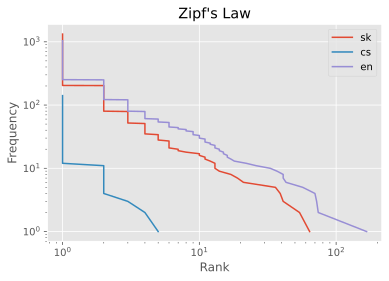

In [12]:
do_law_of_zipf(data_raw)

<a id='task2'></a>
# Task 2: Data Cleaning and Preprocessing

In [0]:
def preprocess(text):
    '''
    Removes punctuation and digits from a string, and converts all characters to lowercase. 
    Also clears all \n and hyphens (splits hyphenated words into two words).
    
    '''
        
    preprocessed_text = text.lower().replace('-', ' ')
    # string.punctuation - punctuation list
    translation_table = str.maketrans('\n', ' ', string.punctuation+string.digits)
    
    preprocessed_text = preprocessed_text.translate(translation_table)
        
    return preprocessed_text

In [0]:
data_preprocessed = {k: [preprocess(sentence) for sentence in v] for k, v in data_raw.items()}

In [15]:
show_statistics(data_preprocessed)

Language: sk
-----------------------
Number of sentences	:	 0
Number of words		:	 0
Number of unique words	:	 0
Sample extract		:	 ...

Language: cs
-----------------------
Number of sentences	:	 0
Number of words		:	 0
Number of unique words	:	 0
Sample extract		:	 ...

Language: en
-----------------------
Number of sentences	:	 0
Number of words		:	 0
Number of unique words	:	 0
Sample extract		:	 ...



<a id='task3'></a>
# Task 3: The Naive Bayes Model

**Bayes' Theorem**

\begin{equation}
P(A | B)=\frac{P(B | A) \times P(A)}{P(B)}
\end{equation}

Now, let's translate this theory into our specific problem. In our case, where we want to categorise a sentence `my name is Ari` into one of `sk`, `cs`, or `en`, the following are the probabilities we want to determine.

\begin{equation}
P(\text {sk} | \text {my name is Ari})=\frac{P(\text {my name is Ari} | \text {sk}) \times P(\text {sk})}{P(\text {my name is Ari})}
\end{equation}

\begin{equation}
P(\text {cs} | \text {my name is Ari})=\frac{P(\text {my name is Ari} | \text {cs}) \times P(\text {cs})}{P(\text {my name is Ari})}
\end{equation}

\begin{equation}
P(\text {en} | \text {my name is Ari})=\frac{P(\text {my name is Ari} | \text {en}) \times P(\text {en})}{P(\text {my name is Ari})}
\end{equation}

## Unseen Data

Since we assume conditional independence across our features, our numerator term for any of the above equations can be broken into the following.

\begin{equation}
P(\text {my name is Ari} | \text {en}) = P(\text {my} | \text {en}) \times P(\text {name} | \text {en}) \times P(\text {is} | \text {en}) \times P(\text {Ari} | \text {en})
\end{equation}

## Vectorizing Training Data

|Sentence   	||   my   	| is 	| I 	| love 	| name 	| it 	| Ari 	|
|-----------------	||:------:	|:--:	|:-:	|:----:	|:----:	|:--------:	|:---:	|
| my name is Ari  	||    1   	|  1 	| 0 	|   0  	|   1  	|     0    	|  1  	|
| I love it 	||    0   	|  0 	| 1 	|   1  	|   0  	|     1    	|  0  	|

In [0]:
sentences_train, y_train = [], []

for k, v in data_preprocessed.items():
    for sentence in v:
        sentences_train.append(sentence)
        y_train.append(k)

In [0]:
vectorizer = CountVectorizer()

In [0]:
X_train = vectorizer.fit_transform(sentences_train)

In [19]:
X_train

<210x2208 sparse matrix of type '<class 'numpy.int64'>'
	with 3867 stored elements in Compressed Sparse Row format>

## Initializing Model Parameters and Training

In [20]:
naive_classifier = MultinomialNB()
naive_classifier.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

## Vectorizing Validation Data and Evaluating Model

In [0]:
data_val = dict()
data_val['sk'] = open_file('/content/drive/My Drive/Colab Notebooks/LanguageClassificationProject/Data/Sentences/val_sentences.sk')
data_val['cs'] = open_file('/content/drive/My Drive/Colab Notebooks/LanguageClassificationProject/Data/Sentences/val_sentences.cs')
data_val['en'] = open_file('/content/drive/My Drive/Colab Notebooks/LanguageClassificationProject/Data/Sentences/val_sentences.en')

data_val_preprocessed = {k: [preprocess(sentence) for sentence in v] for k, v in data_val.items()}

In [0]:
sentences_val, y_val = [], []

for k, v in data_val_preprocessed.items():
    for sentence in v:
        sentences_val.append(sentence)
        y_val.append(k)

In [0]:
X_val = vectorizer.transform(sentences_val)

In [0]:
predictions = naive_classifier.predict(X_val)

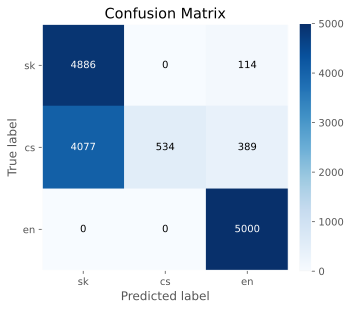

In [25]:
plot_confusion_matrix(y_val, predictions, ['sk', 'cs', 'en'])

# 5000 observations are taken for each language
# Best results are obtained when the maximum observations are present on the diagonal line
# Too many false predictions as two languages (Czech and Slovak) are similar

In [26]:
# Another evaluation metric
f1_score(y_val, predictions, average='weighted')

0.6149824401040264

<a id='task4'></a>
# Task 4: Simple Adjustments and Highlighting Model Shortcomings

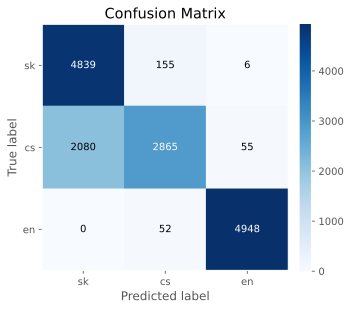

In [27]:
# Created new Naive Bayes classifier to improve the classification performance of the model
# fit_prior=False - to prevent fitting of the model to a language more because of more training data etc.

naive_classifier = MultinomialNB(alpha=0.0001, fit_prior=False)
naive_classifier.fit(X_train, y_train)

predictions = naive_classifier.predict(X_val)

plot_confusion_matrix(y_val, predictions, ['sk', 'cs', 'en'])

In [28]:
f1_score(y_val, predictions, average='weighted')

0.8368507601649364

<a id='task5'></a>
# Task 5: Using Subwords to Shift Perspective

**Dummy Dataset**

playing ; eating ; play ; reads ; tea

**Step 1**

Break each word into characters

playing > p l a y i n g


**Step 2**

Find common character sequences

ea, ing, play

**Step 3**

Convert dataset using these subwords into

play ing ; ea t ing ; play ; r ea d s ; t ea

In [0]:
# taken from https://arxiv.org/abs/1508.07909

import re, collections
def get_stats(vocab):
    pairs = collections.defaultdict(int) 
    for word, freq in vocab.items():
        symbols = word.split()
        for i in range(len(symbols)-1):
            pairs[symbols[i],symbols[i+1]] += freq 
    return pairs

def merge_vocab(pair, v_in):
    v_out = {}
    bigram = re.escape(' '.join(pair))
    p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
    for word in v_in:
        w_out = p.sub(''.join(pair), word)
        v_out[w_out] = v_in[word] 
    return v_out

In [0]:
def get_vocab(data):

    words = []
    for sentence in data:
        words.extend(sentence.split())
        
    vocab = defaultdict(int)
    for word in words:
        vocab[' '.join(word)] += 1
        
    return vocab

In [0]:
vocab = get_vocab(sentences_train)

In [0]:
# also taken from original paper
for i in range(100):
    pairs = get_stats(vocab)
    best = max(pairs, key=pairs.get) 
    vocab = merge_vocab(best, vocab)

In [0]:
merges = defaultdict(int)
for k, v in vocab.items():
    for subword in k.split():
        if len(subword) >= 2:
            merges[subword] += v

In [0]:
merge_ordered = sorted(merges, key=merges.get, reverse=True)

In [0]:
pkl.dump(merge_ordered, open('/content/drive/My Drive/Colab Notebooks/LanguageClassificationProject/Data/Auxiliary/merge_ordered.pkl', 'wb'))

In [0]:
def split_into_subwords(text):
    merges = pkl.load(open('/content/drive/My Drive/Colab Notebooks/LanguageClassificationProject/Data/Auxiliary/merge_ordered.pkl', 'rb'))
    subwords = []
    for word in text.split():
        for subword in merges:
            subword_count = word.count(subword)
            if subword_count > 0:
                word = word.replace(subword, ' ')
                subwords.extend([subword]*subword_count)
    return ' '.join(subwords)

In [37]:
split_into_subwords('this is ari here')

'is th is ar re'

In [0]:
data_preprocessed_subwords = {k: [split_into_subwords(sentence) for sentence in v] for k, v in data_preprocessed.items()}

In [39]:
show_statistics(data_preprocessed_subwords)

Language: sk
-----------------------
Number of sentences	:	 0
Number of words		:	 0
Number of unique words	:	 0
Sample extract		:	 ...

Language: cs
-----------------------
Number of sentences	:	 0
Number of words		:	 0
Number of unique words	:	 0
Sample extract		:	 ...

Language: en
-----------------------
Number of sentences	:	 0
Number of words		:	 0
Number of unique words	:	 0
Sample extract		:	 ...



In [0]:
data_train_subwords = []
for sentence in sentences_train:
    data_train_subwords.append(split_into_subwords(sentence))

In [0]:
data_val_subwords = []
for sentence in sentences_val:
    data_val_subwords.append(split_into_subwords(sentence))

In [0]:
vectorizer = CountVectorizer()

In [0]:
X_train = vectorizer.fit_transform(data_train_subwords)
X_val = vectorizer.transform(data_val_subwords)

In [44]:
naive_classifier = MultinomialNB(fit_prior=False)
naive_classifier.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=False)

In [0]:
predictions = naive_classifier.predict(X_val)

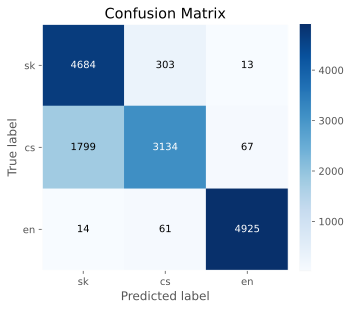

In [46]:
plot_confusion_matrix(y_val, predictions, ['sk', 'cs', 'en'])

In [47]:
f1_score(y_val, predictions, average='weighted')

0.8456381060126386

In [0]:
# Saving final models
# joblib.dump(naive_classifier, 'Data/Models/final_model.joblib')
# joblib.dump(vectorizer, 'Data/Vectorizers/final_model.joblib')

In [0]:
str1 = "7"
  
# specify to replace with 
str2 = "Z"
  
# delete chars 
str3 = "123456890"
  
# target string  
text = "weeksyour0123456789weeks"=-
table = trg.maketrans(str1, str2, str3) 
# print (trg.translate(table))

print(text.translate(text.maketrans("7", "Z", "123456890")))